# **GE - TP: Segmentation avec PyTorch**


Dans ce TP, nous allons coder un réseau de neurones pour segmenter des tumeurs sur des scan de cerveau.

# **1. Imports**

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.utils.tensorboard
import torchvision
import torchvision.transforms
import os
import time
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.model_selection as model_selection
from tqdm import tqdm
from glob import glob
from IPython.display import clear_output

!pip install SimpleITK

import SimpleITK as sitk

!pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 15.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **2. Database**



## 2.a. Télécharger la base de données.

Exécutez la cellule suivante pour télécharger la base de données.

In [ ]:
!git clone https://github.com/soniamartinot/Brats.git

## 2.b. Aperçu de la base de données.

Les données se trouvent dans le dossier `/Brats/`.

Dans ce dossier, vous trouverez:

> Le dossier `origin_data` : contient 4 patients.
>- Pour chaque patient, vous trouverez un volume entier par modalité sous format nifti.
>- Chaque volume est de taille `(155, 192, 192)`

> Le dossier `data` contient 336 patients.
>- Les images dans ce dossier ont été pré-traitées et ont maintenant une taille de `(78, 96, 96)`. La taille plus petite rendra l'entraînement des modèles plus rapide et moins gourmand en ressoures.
>- Si on considère un patient `BraTS19_EXAMPLE`, son dossier s'appellera `/Brats/data/BraTS19_EXAMPLE`. Dans ce dossier, vous trouverez des fichiers nifti (`.nii.gz`) pour chaque modalité, et pour chaque coupe selon l'axe Z.
>- Il y a 78 coupes par volume, i.e. 78 coupes par modalité.



In [ ]:
# The data is store in the folder /Brats/
data_path = './Brats/data/'
original_data_path = './Brats/origin_data/'

### **i. Contenu de la base de données**

In [ ]:
# Original data
print("Content of the folder:\n", os.listdir(original_data_path))
patient = "BraTS19_TCIA01_131_1"
print("Content of a patient's folder:\n", os.listdir(original_data_path + patient))

In [ ]:
# Processed data
files = os.listdir(data_path) # All the files in the folder /Brats/data/
print('Content of the folder {} \n: {}'.format(data_path, files[:5]))
print('Number of files for each patient : {}'.format(len(os.listdir(data_path + files[0])) ))
print('Number of patients in {} : {}'.format(data_path, len(files)))

### **ii. Contenu du dossier d'un patient**

Pour chaque patient, vous trouverez 4 modalités et les masques de segmentation:

- t1
- t2
- flair
- t1ce (gado)
- seg
    
Pour chqaue modalité, vous trouverez un fichier pour chaque coupe selon l'axe Z. Chaque patient a **78 coupes** par modalité.

In [ ]:
modalities = ['t1', 't2', 't1ce', 'flair', 'seg']

In [ ]:
patient = 'BraTS19_2013_20_1'
patient_path = os.path.join(data_path, patient)
patient_files = os.listdir(patient_path)
patient_files[:10]

In [ ]:
"""
Filter for the Flair modality
"""

flair_modality_files = sorted([e for e in patient_files if 'flair' in e])
print("Number of Z slices:", len(flair_modality_files))
flair_modality_files[-5:]

### **iii. SimpleITK tutorial**

On utilise le package Python `SimpleITK` pour lire les fichiers nifti de la base de données.

Pour ouvrir une image nifti, il faut utiliser la fonction suivante:

        image = sitk.ReadImage(image_path)

Grâce à ce package, vous avez accès à des informations pertinentes, physiques ou médicales, sur chaque image:
- spacing: `image.GetSpacing()`
- direction: `image.GetDirection()`
- origine: `image.GetOrigin()`
- taille: `image.GetSize()`
- metadata: `image.GetMetaDataKeys()`
- valeur d'un pixel: `image.GetPixel(pixel_x, pixel_y, pixel_z)`

Vous pouvez passer d'une image `sitk` à un array `numpy` grâce à la commande suivante:

        array = sitk.GetArrayFromImage(image)

In [ ]:
patient = 'BraTS19_CBICA_ANP_1'

# Define the image path
z = 3
modality = 'flair'
patient_folder = os.path.join(original_data_path, patient)
image_name = "{patient}_{modality}.nii.gz".format(patient=patient, modality=modality)
image_path = os.path.join(patient_folder, image_name)
print("Path to the image:", image_path)
# We use the librairy sitk to open the nifti images
image = sitk.ReadImage(image_path)
print("Type of the opened image:", type(image))
print(f"Size of the simpleITK image object: {image.GetSize()}")

In [ ]:
# Print geometrical information
print('Image Direction : {}'.format(image.GetDirection()))
print('Image Spacing : {}'.format(image.GetSpacing()))
print('Image Origin : {}'.format(image.GetOrigin()))
print('Image Size : {}'.format(image.GetSize()))
print('Pixel value:', image.GetPixel(0, 0, 0))

In [ ]:
# Get all the information in the meta data
keys = image.GetMetaDataKeys()
print('Metadata :')
for key in keys:
    print('{} : {}'.format(key, image.GetMetaData(key)))

Metadata :
ITK_FileNotes : 
ITK_original_direction : [UNKNOWN_PRINT_CHARACTERISTICS]

ITK_original_spacing : [UNKNOWN_PRINT_CHARACTERISTICS]

aux_file : 
bitpix : 16
cal_max : 0
cal_min : 0
datatype : 4
descrip : 
dim[0] : 3
dim[1] : 240
dim[2] : 240
dim[3] : 155
dim[4] : 1
dim[5] : 1
dim[6] : 1
dim[7] : 1
dim_info : 0
intent_code : 0
intent_name : 
intent_p1 : 0
intent_p2 : 0
intent_p3 : 0
nifti_type : 1
pixdim[0] : 0
pixdim[1] : 1
pixdim[2] : 1
pixdim[3] : 1
pixdim[4] : 0
pixdim[5] : 0
pixdim[6] : 0
pixdim[7] : 0
qform_code : 1
qform_code_name : NIFTI_XFORM_SCANNER_ANAT
qoffset_x : 0
qoffset_y : 239
qoffset_z : 0
quatern_b : 0
quatern_c : 0
quatern_d : 1
scl_inter : 0
scl_slope : 0
sform_code : 1
sform_code_name : NIFTI_XFORM_SCANNER_ANAT
slice_code : 0
slice_duration : 0
slice_end : 0
slice_start : 0
srow_x : -1 -0 -0 0
srow_y : -0 -1 -0 239
srow_z : 0 0 1 0
toffset : 0
vox_offset : 2880
xyzt_units : 2


In [ ]:
# Convert the sitk image
array = sitk.GetArrayFromImage(image)
print("Type of the image:", type(array)) # Type of the image
print("Shape of the image as a numpy array:", array.shape)
print("Value of the first pixel of the numpy array:", array[0, 0, 0])

Type of the image: <class 'numpy.ndarray'>
Shape of the image as a numpy array: (155, 240, 240)
Value of the first pixel of the numpy array: 0


### **iv. Comparaison entre les données originales et pré-traitées.**


Afin d'accélérer les temps de calcul pour obtenir de bons résultats plus rapidement, les images d'origine de taille `(155, 240, 240)` ont été pré-traitées selon les étapes suivantes:
- Crop les images à la taille `(155, 192, 192)`
- Réduire la résolution des images par interpolation d'échelle 0.5 (https://scikit-image.org/docs/dev/auto_examples/transform/plot_rescale.html) jusqu'à une taille de `(78, 96, 96)`
- Sauvegarder les coupes de l'axe Z de façon **indépendemment** les unes des autres dans de nouveaux array de taille `(96, 96)`



Original array shape : (155, 240, 240)
Processed array shape : (96, 96)


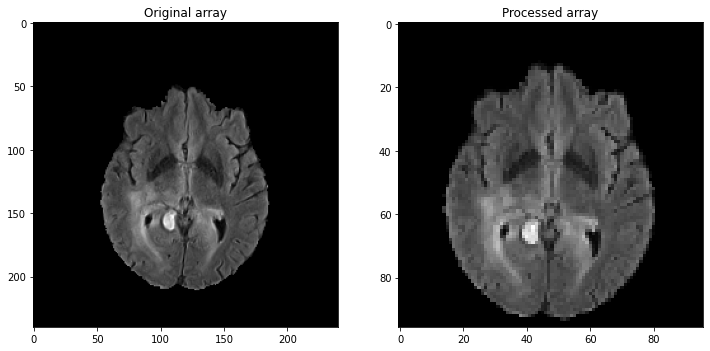

In [ ]:
patient = 'BraTS19_CBICA_ANP_1'

# Define the image path in the original data
z = 3
modality = 'flair'
patient_folder = os.path.join(original_data_path, patient)
image_name = "{patient}_{modality}.nii.gz".format(patient=patient, modality=modality)
image_path = os.path.join(patient_folder, image_name)

# We use the librairy sitk to open the nifti images
image = sitk.ReadImage(image_path)
orig_array = sitk.GetArrayFromImage(image)
print('Original array shape : {}'.format(orig_array.shape))

# open corresponding preprocessed data slice
patient_folder = os.path.join(data_path, patient)
z_slice = 35
path = os.path.join(patient_folder, "{patient}_{modality}_z_{z_slice}.nii.gz".format(patient=patient, modality=modality, z_slice=z_slice))
image = sitk.ReadImage(path)
processed_array = sitk.GetArrayFromImage(image)
print('Processed array shape : {}'.format(processed_array.shape))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(orig_array[z_slice*2, :, :], cmap='gray')
plt.title('Original array')
plt.subplot(1, 2, 2)
plt.imshow(processed_array, cmap='gray')
plt.title('Processed array')
plt.show()

### **v. Visualiser toutes les modalités.**


Considérons un patient dans le dossier `data`. Plot chaque modalité côte à côte en itérant sur les coupes Z disponibles.

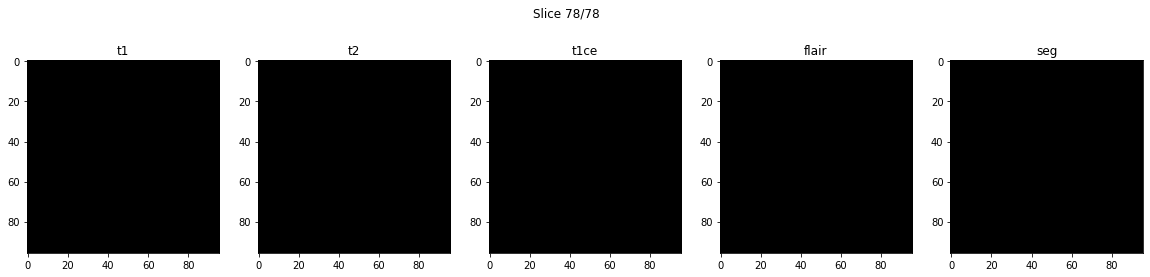

In [ ]:
# Go over each Z slice
for z in range(len(flair_modality_files)):
    f, axes = plt.subplots(1, 5, figsize=(20, 6))

    # Plot each modality for that slice
    for i, modality in enumerate(modalities):
        # Fetch the modality-slice file and open using SimpleITK
        file_path = data_path + "{patient}/{patient}_{modality}_z_{z}.nii.gz".format(patient=patient, modality=modality, z=z)
        slice = sitk.GetArrayFromImage(sitk.ReadImage(file_path))

        # Plot the slice

        axes[i].set_title(modality)
        axes[i].imshow(slice, cmap="gray")

    plt.suptitle("Slice {}/{}".format(z+1, len(flair_modality_files)), y=0.85)
    plt.show()
    clear_output(wait=True)

## 2.c. Création des train, validation et test sets


Les train, validation et test sets sont indiqués dans le dossier `/Brats/datasets`. Pour chaque set, vous trouverez un fichier texte contenant une liste de patients à inclure dans le set.


Exécutez le code suivant afin de:
*   Charger les train, validation et test sets.
*   Afficher les 5 premiers patients du train set.
*   Afficher la longueur des train, validation et test sets.

In [ ]:
datasets_path = './Brats/datasets/'

train_set = np.loadtxt(datasets_path + 'train.txt', dtype=str)
validation_set = np.loadtxt(datasets_path + 'val.txt', dtype=str)
test_set = np.loadtxt(datasets_path + 'test.txt', dtype=str)

# Train_set, validation_set and test_set are list of patients
print('Train set, first 5 patients : {}\n'.format(train_set[:5])) # Print the first 5 patients of train_set
print('Train set length :\t {}'.format(len(train_set)))
print('Validation set length :\t {}'.format(len(validation_set)))
print('Test set length :\t {}'.format(len(test_set)))

Train set, first 5 patients : ['BraTS19_CBICA_BHQ_1' 'BraTS19_CBICA_AQV_1' 'BraTS19_CBICA_ATN_1'
 'BraTS19_TCIA01_335_1' 'BraTS19_CBICA_ASY_1']

Train set length :	 251
Validation set length :	 42
Test set length :	 42


# **3. Creation du réseau de neurones**

Dans cette partie, nous allons coder un [**UNet**](https://arxiv.org/pdf/1505.04597.pdf). Les UNets sont particulièrement utilisés pour des tâches de segmentation dans le domaine de l'imagerie médicale. Vous pouvez étudier son architecture dans la figure suivante.

Le UNet a deux principales caractéristiques:

1.   La taille de l'image d'entrée est divisée par 2 à chaque bloc par une couche appelée `MaxPooling` dans la partie **encoder** du modèle. dans la partie **decoder**, les features extraites sont progressivement suréchantillonnées par des Transpose Convolution  (`ConvTranspose2d` in PyTorch) jusqu'à retrouver la taille de l'image d'entrée.

2.   Afin de conserver des informations de haute résolution, le modèle est doté de **skip-connections** qui passent de l'information entre l'encoder et le decoder.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)



## 3.a. Création du réseau


**Nota bene**: Sur la figure descriptive du UNet, le nombre de canaux évolue de 64 -> 128 -> 256 -> 512 -> 1024 ... Le modèle correspondant nécessite plus de RAM que ce qui est disponible sur colab.

En conséquence, nous reproduirons le UNet en commençant par le nombre de canaux 16 puis 32 -> 64 -> 128 -> 256 ...

### **i. Building blocks**

Analyse de code: que fait la fonction `get_activation` ?

In [ ]:
def get_activation(activation_type):
    activation_type = activation_type.lower()
    if hasattr(nn, activation_type):  return getattr(nn, activation_type)()
    else:  return nn.ReLU()

>**Complétez la classe `ConvBatchNorm`.** Vous aurez besoin de:
>- `get_activation`
>- `BatchNorm2d`
>- `Conv2d`

Cett classe contient une méthode `forward`, dont l'entrée `x` passera par les différentes couches Pytorch définies dans l'initialisation de la classe.

Afin de tester l'implémentation de votre classe:
-  nous allons  créer un Tensor Pytorch nommé `x` de taille `(4, 1, 96, 96)` à valeurs aléatoires, avec la fonction `torch.rand`.
- Donner ce Tensor en argument de la méthode `forward`. Si
votre code est correct, aucune erreur ne devrait apparaître.

In [ ]:
class ConvBatchNorm(nn.Module):
    """This block implements the sequence: (convolution => [BN] => ReLU)"""
    def __init__(self, in_channels, out_channels, activation='ReLU'):
        super(ConvBatchNorm, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size=3, padding=1)
        self.norm = nn.BatchNorm2d(out_channels)
        self.activation = get_activation(activation)

    def forward(self, x):
        out = self.conv(x)
        out = self.norm(out)
        return self.activation(out)


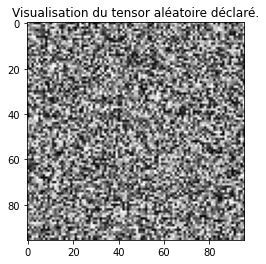

In [ ]:
# Création du tensor de test

x = torch.rand(4, 1, 96, 96)

plt.imshow(x[0, 0], cmap="gray")
plt.title("Visualisation du tensor aléatoire déclaré.")
plt.show()

Taille du tensor d'entrée: torch.Size([4, 1, 96, 96])
Taille du tensor de sortie: torch.Size([4, 64, 96, 96])


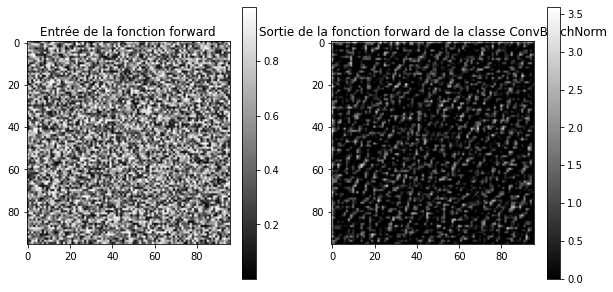

In [ ]:
test_conv = ConvBatchNorm(1, 64)


y = test_conv(x)

print(f"Taille du tensor d'entrée: {x.shape}")
print(f'Taille du tensor de sortie: {y.shape}')

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(x[0, 0], cmap="gray")
plt.title("Entrée de la fonction forward")
plt.colorbar()
plt.subplot(122)
plt.imshow(y[0, 0].detach(), cmap="gray")
plt.title('Sortie de la fonction forward de la classe ConvBatchNorm')
plt.colorbar()
plt.show()

Analyse de code: Que fait la fonction `_make_nConv` ?

In [ ]:
def _make_nConv(in_channels, out_channels, nb_Conv, activation='ReLU'):
    layers = []
    layers.append(ConvBatchNorm(in_channels, out_channels, activation))
    for _ in range(nb_Conv-1):
        layers.append(ConvBatchNorm(out_channels, out_channels, activation))
    return nn.Sequential(*layers)

A l'aide de la classe `ConvBatchNorm`, nous pouvons ainsi créer les building blocks du UNet:
>- `DownConvBlock`: cette classe sera utilisée pour construire la partie **encoder**  du UNet.
>- `UpConvBlock`: cette classe sera utilisée pour construire la partie **decoder** du UNet.

Ces classes utilises les couches Pytorch suivante:
>- `MaxPool2d` pour la réduction des dimensions spatiales dans l'encoder,
>- `ConvTransposed2d` ou `Upsample` pour l'augmentation des dimensions spatiales dans le decoder,
>- `ReLU`, fonction d'activation utilisée dans chaque bloc.

In [ ]:
class DownBlock(nn.Module):
    """Downscaling with maxpooling and convolutions"""
    def __init__(self, in_channels, out_channels, nb_Conv, activation='ReLU'):
        super(DownBlock, self).__init__()
        self.maxpool = nn.MaxPool2d(2)
        self.nConvs = _make_nConv(in_channels, out_channels, nb_Conv, activation)

    def forward(self, x):
        out = self.maxpool(x)
        return self.nConvs(out)

class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, nb_Conv=2, activation='ReLU'):
        super(Bottleneck, self).__init__()
        self.nConvs = _make_nConv(in_channels, out_channels, nb_Conv, activation)

    def forward(self, input):
        out = self.nConvs(input)
        return out

class UpBlock(nn.Module):
    """Upscaling then conv"""
    def __init__(self, in_channels, out_channels, nb_Conv=2, activation='ReLU'):
        super(UpBlock, self).__init__()
        self.up = nn.Upsample(scale_factor=2)
        self.nConvs = _make_nConv(in_channels, out_channels, nb_Conv, activation)

    def forward(self, x, skip_x):
        out = self.up(x)
        x = torch.cat([out, skip_x], dim=1) # dim 1 is the channel dimension
        return self.nConvs(x)

Taille de l'entrée et de la sortie d'un DownBlock: torch.Size([4, 64, 96, 96]) -  torch.Size([4, 128, 48, 48])


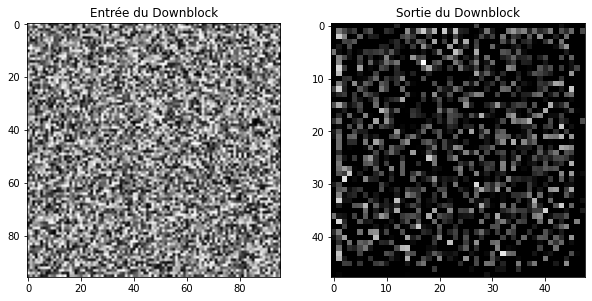

Taille de l'entrée et de la sortie du Bottleneck: torch.Size([4, 128, 48, 48]) -  torch.Size([4, 128, 48, 48])


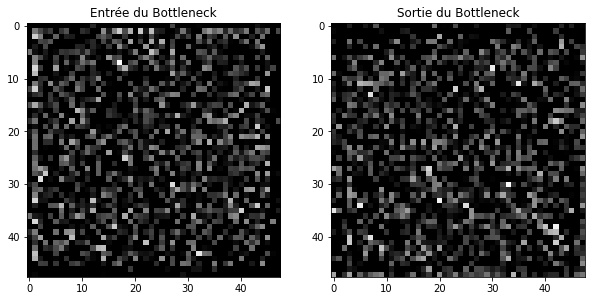

Taille de l'entrée et de la sortie d'un UpBlock: torch.Size([4, 128, 48, 48]) -  torch.Size([4, 64, 96, 96])


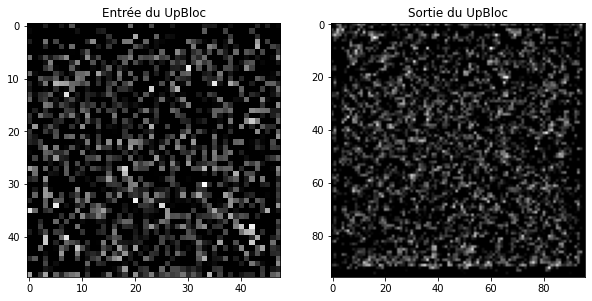

In [ ]:
# Testez les implémentations de chaque bloc

test_down = DownBlock(64, 128, nb_Conv=2)
x = torch.rand(4, 64, 96, 96)
y = test_down(x)
print(f"Taille de l'entrée et de la sortie d'un DownBlock: {x.shape} -  {y.shape}")


plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(x[0, 0], cmap="gray")
plt.title("Entrée du Downblock")
plt.subplot(122)
plt.imshow(y[0, 0].detach(), cmap="gray")
plt.title("Sortie du Downblock")
plt.show()


test_bottleneck = Bottleneck(128, 128, nb_Conv=2)
y_bottleneck = test_bottleneck(y)
print(f"Taille de l'entrée et de la sortie du Bottleneck: {y.shape} -  {y_bottleneck.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(y[0, 0].detach(), cmap="gray")
plt.title("Entrée du Bottleneck")
plt.subplot(122)
plt.imshow(y_bottleneck[0, 0].detach(), cmap="gray")
plt.title("Sortie du Bottleneck")
plt.show()

test_up = UpBlock(256, 64, nb_Conv=2)
x_skip = torch.rand(4, 128, 96, 96)
y_up = test_up(y_bottleneck, x_skip)
print(f"Taille de l'entrée et de la sortie d'un UpBlock: {y_bottleneck.shape} -  {y_up.shape}")


plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(y_bottleneck[0, 0].detach(), cmap="gray")
plt.title("Entrée du UpBloc")
plt.subplot(122)
plt.imshow(y_up[0, 0].detach(), cmap="gray")
plt.title("Sortie du UpBloc")
plt.show()

### **ii. UNet architecture**

Ici vous utiliserez les building blocks codés précédemment pour construire l'architecture complète du UNet.

- Soyez vigilant aux nombres de canaux d'entrée et de sortie de chaque bloc lorsque vous implémentez les skip connections.

- Comparez le code suivant avec la figure du UNet. Où sont les `DownConvBlock`, les `UpConvBlock` ?

In [ ]:
class DownBlock(nn.Module):
    """Downscaling with maxpooling and convolutions"""
    def __init__(self, in_channels, out_channels, nb_Conv, activation='ReLU'):
        super(DownBlock, self).__init__()

        self.maxpool = nn.MaxPool2d(2)
        self.nConvs = _make_nConv(in_channels, out_channels, nb_Conv, activation)

    def forward(self, x):
        out_maxpool = self.maxpool(x)
        out_nconvs = self.nConvs(out_maxpool)
        return out_nconvs

class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, nb_Conv=2, activation='ReLU'):
        super(Bottleneck, self).__init__()
        self.nConvs = _make_nConv(in_channels, out_channels, nb_Conv, activation)


    def forward(self, input):
        out = self.nConvs(input)
        return out

class UpBlock(nn.Module):
    """Upscaling then conv"""
    def __init__(self, in_channels, out_channels, nb_Conv=2, activation='ReLU'):
        super(UpBlock, self).__init__()

        self.up = nn.Upsample(scale_factor=2)
        self.nConvs = _make_nConv(in_channels, out_channels, nb_Conv, activation)

    def forward(self, x, skip_x):

        out_up = self.up(x)

        # Skip connection (use torch.cat function)
        x = torch.cat([out_up, skip_x], dim=1)
        return self.nConvs(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels=4, n_classes=4, verbose=False):
        '''
        n_channels : number of channels of the input.
                        By default 4, because we have 4 modalities
        n_labels : number of channels of the ouput.
                      By default 4 (3 labels + 1 for the background)
        '''
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.verbose = verbose

        # Question here

        self.inc = ConvBatchNorm(n_channels, 16)
        self.down1 = DownBlock(16, 32, nb_Conv=2)
        self.down2 = DownBlock(32, 64, nb_Conv=2)
        self.down3 = DownBlock(64, 128, nb_Conv=2)
        self.down4 = DownBlock(128, 128, nb_Conv=2)

        self.Encoder = [self.down1, self.down2, self.down3, self.down4]

        self.bottleneck = Bottleneck(128, 128)

        self.up1 = UpBlock(256, 64, nb_Conv=2)
        self.up2 = UpBlock(128, 32, nb_Conv=2)
        self.up3 = UpBlock(64, 16, nb_Conv=2)

        self.Decoder = [self.up1, self.up2, self.up3]

        self.outc = nn.Sequential(nn.ConvTranspose2d(16, 16,
                                                     kernel_size=3, stride=2,
                                                     padding=1, output_padding=1),
                                  nn.Conv2d(16, self.n_classes, kernel_size=3, stride=1, padding=1)
                                  )
        self.last_activation = get_activation('Softmax')


    def forward(self, x):
        # Forward
        skip_inputs = []
        x = self.inc(x)

        # Forward through encoder
        for i, block in enumerate(self.Encoder):

            x = block(x)
            skip_inputs += [x]
            if self.verbose: print(f"Size of block {i} of the encoder: {x.shape}")

        # We are at the bottleneck.
        bottleneck = self.bottleneck(x)

        # Forward through decoder
        skip_inputs.reverse()

        decoded = bottleneck
        for i, block in enumerate(self.Decoder):

            # Concat with skipconnections
            skipped = skip_inputs[i+1]

            decoded = block(decoded, skipped)
            if self.verbose: print(f"Size of the skipped input and output of block {i} of the decoder: {skipped.shape} - {decoded.shape}")
        out = self.last_activation(self.outc(decoded))
        return out

## 3.b. Analyse du modèle.

> Pour étudier et débugger le modèle, vous pouvez lui donner en entrée un tensor random de taille `(1, 4, 96, 96)` (batch size, number of modalites, image shape) avec la fonction `torch.rand`.

> La taille de la sortie du réseau doit être la même que celle de l'image d'entrée.

> Pour mieux débugger, il vous faudra peut être modifier votre code pour affichier les tailles des sorties de chaque couche du réseau .



In [ ]:

unet_model = UNet(n_channels=4, n_classes=4, verbose=True)
print(unet_model)

UNet(
  (inc): ConvBatchNorm(
    (conv): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (down1): DownBlock(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (nConvs): Sequential(
      (0): ConvBatchNorm(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (1): ConvBatchNorm(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
    )
  )
  (down2): DownBlock(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (nConvs): Sequential(
    

Size of block 0 of the encoder: torch.Size([4, 32, 48, 48])
Size of block 1 of the encoder: torch.Size([4, 64, 24, 24])
Size of block 2 of the encoder: torch.Size([4, 128, 12, 12])
Size of block 3 of the encoder: torch.Size([4, 128, 6, 6])
Size of the skipped input and output of block 0 of the decoder: torch.Size([4, 128, 12, 12]) - torch.Size([4, 64, 12, 12])
Size of the skipped input and output of block 1 of the decoder: torch.Size([4, 64, 24, 24]) - torch.Size([4, 32, 24, 24])
Size of the skipped input and output of block 2 of the decoder: torch.Size([4, 32, 48, 48]) - torch.Size([4, 16, 48, 48])
Taille de l'entrée et de la sortie du UNet: torch.Size([4, 4, 96, 96]) - torch.Size([4, 4, 96, 96])


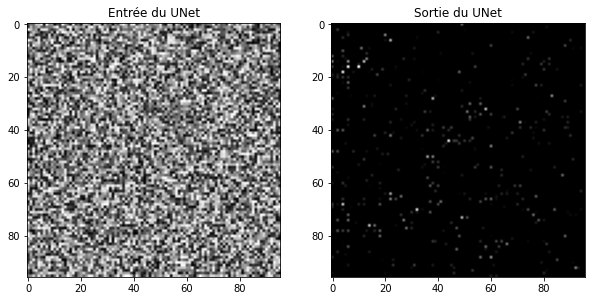

In [ ]:
# Testez votre UNet
x = torch.rand(4, 4, 96, 96)
y = unet_model(x)

print(f"Taille de l'entrée et de la sortie du UNet: {x.shape} - {y.shape}")
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(x[0, 0], cmap="gray")
plt.title("Entrée du UNet")
plt.subplot(122)
plt.imshow(y[0, 0].detach(), cmap="gray")
plt.title("Sortie du UNet")
plt.show()

# **4. Création du dataset**



## 4.a. Fonctions utiles -  CODE A EXECUTER ET A CACHER


Le code suivant est nécessaire pour entraîner correctement le modèle et est déjà codé.

Exécutez la cellule suivante. Vous pouvez essayer de comprendre ce que chaque fonction fait.

In [ ]:
end = '.nii.gz'
seg_name = '_seg'

def load_split(split_folder):
    '''
        return train, val, test split with loadtxt
    '''
    train_split = np.loadtxt(os.path.join(
        split_folder, 'train.txt'), dtype=str)
    val_split = np.loadtxt(os.path.join(split_folder, 'val.txt'), dtype=str)
    test_split = np.loadtxt(os.path.join(split_folder, 'test.txt'), dtype=str)
    return train_split, val_split, test_split


def load_sitk(path):
    return sitk.GetArrayFromImage(sitk.ReadImage(path))


def find_z_slice(list_patient, threshold, dataframe):
    """
    For each patient in list_patient, this function returns the list of slices where
    the corresponding image is not empty"""

    list_IDs = []
    for patient in list_patient:
        if threshold > 0:
            condition = dataframe[patient].values >= threshold
            z_slice = np.where(condition)[0]
        else:
            z_slice = range(155)
        list_IDs += list(set([(patient, int(z//2)) for z in z_slice]))

    return list_IDs


def generate_IDs(train_split, val_split, test_split,
                 tumor_percentage, csv_path, image_size=(240, 240)):

    tumor_volume_dataframe = pd.read_csv(csv_path)
    threshold = int(tumor_percentage * np.prod(image_size) / 100)

    train_IDs, val_IDs, test_IDs = [], [], []
    train_IDs = find_z_slice(train_split, threshold, tumor_volume_dataframe)
    val_IDs = find_z_slice(val_split, threshold, tumor_volume_dataframe)
    test_IDs = find_z_slice(test_split, 0, tumor_volume_dataframe)
    return train_IDs, val_IDs, test_IDs


def to_var(x, device):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    x = x.to(device)
    return x

def to_numpy(x):
    if not (isinstance(x, np.ndarray) or x is None):
        if x.is_cuda:
            x = x.data.cpu()
        x = x.numpy()
    return x

def save_checkpoint(state, save_path):
    '''
        Save the current model.
        If the model is the best model since beginning of the training
        it will be copy
    '''

    if not os.path.isdir(save_path):
        os.makedirs(save_path)

    epoch = state['epoch']
    val_loss = state['val_loss']
    filename = save_path + '/' + \
        'model.{:02d}--{:.3f}.pth.tar'.format(epoch, val_loss)
    torch.save(state, filename)


def print_summary(epoch, i, nb_batch, loss, batch_time,
                  average_loss, average_time, mode):
    '''
        mode = Train or Test
    '''
    summary = '[' + str(mode) + '] Epoch: [{0}][{1}/{2}]\t'.format(
        epoch, i, nb_batch)

    string = ''
    string += ('Dice Loss {:.4f} ').format(loss)
    string += ('(Average {:.4f}) \t').format(average_loss)
    string += ('Batch Time {:.4f} ').format(batch_time)
    string += ('(Average {:.4f}) \t').format(average_time)

    summary += string
    print(summary)

def plot(irms, masks=None, pred_masks=None):

    kwargs = {'cmap': 'gray'}
    fig, ax = plt.subplots(2, 3, gridspec_kw={'wspace': 0.15, 'hspace': 0.2,
                                              'top': 0.85, 'bottom': 0.1,
                                              'left': 0.05, 'right': 0.95},
                           figsize=(12, 7))
    ax[0, 0].imshow(irms[0, :, :], **kwargs)

    if masks is not None:
        masks = np.argmax(masks, axis=0)
        ax[0, 1].imshow(masks, vmin=0, vmax=3)

    if pred_masks is not None:
        pred_masks = np.argmax(pred_masks, axis=0)
        ax[0, 2].imshow(pred_masks, vmin=0, vmax=3)

    for i in range(3):
        ax[1, i].imshow(irms[i+1, :, :], **kwargs)

    for i in range(2):
        for j in range(3):
            ax[i, j].grid(False)
            ax[i, j].axis('off')
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])

    ax[0, 0].set_title('IRM T1')
    ax[1, 0].set_title('IRM Gado')
    ax[1, 1].set_title('IRM T2')
    ax[1, 2].set_title('IRM Flair')
    ax[0, 1].set_title('Ground Truth Seg')
    ax[0, 2].set_title('Predicted Seg')
    fig.canvas.draw()

    return fig


## 4.b. Classe `Dataset`

In [ ]:
class SegmentationDataset(torch.utils.data.Dataset):
    'Generates data for torch'

    def __init__(self, files_list, data_path, modalities=['t1', 't2', 't1ce', 'flair'], transform=None):
        super(SegmentationDataset, self).__init__()
        self.files_list = files_list
        self.transform = transform
        self.data_path = data_path
        self.modalities = modalities

    def __len__(self):
        return len(self.files_list)

    def __getitem__(self, idx):
        'Get a patient given idx'
        patient = self.files_list[idx]

        # Load the patient's modalities and segmentation masks
        irm, mask = self.load(patient)
        sample = (irm, mask)

        # Apply data transformation
        if self.transform:
            irm, mask = self.transform(sample)
        return (irm, mask, patient)

    def load(self, ID):

        patient, z_slice = ID
        patient_path = os.path.join(self.data_path, patient)

        # Get all modalities for the given slice
        irm = []
        for modality in self.modalities:
            file_name = "{patient}_{modality}_z_{z_slice}.nii.gz".format(patient=patient, modality=modality, z_slice=z_slice)
            path = os.path.join(patient_path, file_name)
            irm.append(load_sitk(path))
        irm = np.stack(irm, axis=0)

        # Get the segmentation mask for the given slice
        seg_name = "{patient}_seg_z_{z_slice}.nii.gz".format(patient=patient, z_slice=z_slice)
        mask_path = os.path.join(patient_path, seg_name)
        mask = load_sitk(mask_path)
        mask[mask == 4] = 3

        # Convert segmentation mask to one-hot encoding
        label = 4
        mask = mask.astype(np.int16)
        mask = np.rollaxis(np.eye(label, dtype=np.uint8)[mask], -1, 0)
        return irm, mask

## 4.c. Génération des différents datasets et des listes de coupes pour chaque patient.

`train_IDs`, `val_IDs` et `test_IDs` sont des variables qui correspondent à la variable `files_list` nécessaire lors de la création d'instance de la classe `SegmentationDataset`.

In [ ]:
# Load the split, generate the IDs list
datasets_path ='./Brats/datasets/'
csv_path = './Brats/data/tumor_count.csv'

# The tumour percentage is the percentage of tumour in an image. It's a threshold
# that is used when selecting relevant slice indexes in a patient's images.
tumour_percentage = 0.5
train_split, val_split, test_split = load_split(datasets_path)

(train_IDs, val_IDs, test_IDs) = generate_IDs(train_split, val_split, test_split, tumour_percentage, csv_path)

In [ ]:
val_IDs[:5]

[('BraTS19_TCIA01_499_1', 27),
 ('BraTS19_TCIA01_499_1', 33),
 ('BraTS19_TCIA01_499_1', 23),
 ('BraTS19_TCIA01_499_1', 30),
 ('BraTS19_TCIA01_499_1', 36)]

## 4.d. Creation des instances de la classe `SegmentationDataset` pour chaque dataset

In [ ]:
# No data augmentation implemented yet.
transformation=None

train_Dataset = SegmentationDataset(train_IDs, data_path=data_path,
                                    transform=transformation)

val_Dataset = SegmentationDataset(val_IDs, data_path=data_path,
                                  transform=transformation)

test_Dataset = SegmentationDataset(test_IDs, data_path=data_path,
                                  transform=transformation)


The following cell calls for a sample of the training set. Running `train_Dataset[0]` actually calls the `__getitem__` method of the `SegmentationDataset` class.

In [ ]:
input_modalities, segmentation_mask, patient = train_Dataset[0]

In [ ]:
print("Shape of the input:", input_modalities.shape)
print("Shape of the segmentation masks:", segmentation_mask.shape)
print("Patient identification:", patient[0])
print("Selected slice:", patient[1])

Shape of the input: (4, 96, 96)
Shape of the segmentation masks: (4, 96, 96)
Patient identification: BraTS19_CBICA_BHQ_1
Selected slice: 47


## 4.e. Création des `DataLoader` utilisés pour l'entraînement.

Pour chaque dataset split (train, validation, test), vous devez spécifier:
- la taille du batch avec la variable `batch_size`.
- s'il faut mélanger le dataset pour donner des batch random de données au modèle avec la varibale `shuffle`.
- s'il faut ignorer le dernier batch incomplet, dans le cas où la taille du dataset n'est pas divisible par la taille de batch choisie, avec la variable `drop_last`. Cette variable est particulièrement utile lorsqu'on utilise du multiprocessing (`num_workers` > 1) dans le `DataLoader`.

In [ ]:
# Define the batch size
batch_size = 64


train_loader = torch.utils.data.DataLoader(train_Dataset,
                                           batch_size=batch_size, shuffle=True,
                                           drop_last=True)

val_loader = torch.utils.data.DataLoader(val_Dataset,
                                         batch_size=batch_size, shuffle=False,
                                         drop_last=True)

test_loader = torch.utils.data.DataLoader(test_Dataset,
                                          batch_size=1, shuffle=False,
                                          drop_last=False)

# **5. Training**

## 5.a. Loss function, optimizer et hyperparamètres

Afin d'entraîner un réseau de neurones, il faut d'abord définir:
- la fonction de perte utilisée pour optimiser les paramètres du modèle(voir [ici](https://pytorch.org/docs/stable/nn.html#loss-functions)),
- l'optimizer (voir [ici](https://pytorch.org/docs/stable/optim.html))
- tous les hyperparamètres correspondant:
> - learning rate: à quel vitesse effectuer la descente de gradient ?
> - weight decay: à quel point régulariser l'apprentissage ?


Pour commencer, vous pouvez:
- Choisir `Adam` comme optimizer
- Utiliser une fonction codée par vos soins. Ici nous allons utiliser une custom Dice loss.

La Dice loss permet de quantifier le recouvrement de deux espaces.

In [ ]:
def dice_loss(input, target):
    smooth = 1.
    target = target.float()
    input = input.float()
    input_flat = input.contiguous().view(-1)
    target_flat = target.contiguous().view(-1)
    intersection = (input_flat * target_flat).sum()
    return 1 - ((2. * intersection + smooth) /
                (input_flat.pow(2).sum() + target_flat.pow(2).sum() + smooth))

def mean_dice_loss(input, target):
    channels = list(range(target.shape[1]))
    loss = 0
    for channel in channels:
        dice = dice_loss(input[:, channel, ...],
                         target[:, channel, ...])
        loss += dice
    return loss / len(channels)


In [ ]:
learning_rate = 1e-4

criterion = mean_dice_loss # Choose loss function
optimizer = torch.optim.Adam(unet_model.parameters(), lr=learning_rate) # Choose optimize

## 5.b. Le modèle

Pour créer une instance de la classe `UNet`, vous devez spécifier:
- le nombre de canaux d'entrée `n_channels` qui devrait être égal au nombre de modalités considérées (soit 4 modalités)
- le nombre de classes de segmentation `n_classes` = 4

In [ ]:
n_modalities = 4
n_classes = 4

In [ ]:
model = UNet(n_channels=n_modalities, n_classes=n_classes) # Create model
model.cuda() # move model to GPU

UNet(
  (inc): ConvBatchNorm(
    (conv): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (down1): DownBlock(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (nConvs): Sequential(
      (0): ConvBatchNorm(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (1): ConvBatchNorm(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
    )
  )
  (down2): DownBlock(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (nConvs): Sequential(
    

## 5.c. Training loop pour une seule époque


Ici, vous devez compléter la fonciton `train_loop`, qui parcours tout le dataset `loader` une seule fois.

Quand le modèle est en entraînement, soit `model.training == True`, il est nécessaire que cette fonction performe aussi la rétropropagation et la mise-à-jour des paramètres du modèle.

In [ ]:
# Train the model
def train_loop(loader, model, criterion, optimizer, writer, epoch):

    logging_mode = 'Train' if model.training else 'Val'


    epoch_time_sum, epoch_loss_sum = [], []


    for i, sample in enumerate(loader, 1):
        start = time.time()
        # Take variable
        (irms, masks, patients) = sample
        # print(irms.shape) # Batch * Number of Modalities * Width * Height

        # Put variables to GPU
        irms = irms.float().cuda()
        masks = masks.float().cuda()

        # compute model prediction
        pred_masks = model(irms)

        # compute loss
        dice_loss = criterion(pred_masks, masks)

        # If in training mode ...
        if model.training:
            # Initialize optimizer gradients to zero
            optimizer.zero_grad()
            # Perform backpropagation
            dice_loss.backward()
            # Update the model's trainable parameters using the computed gradients
            optimizer.step()

        # Compute elapsed time
        batch_time = time.time() - start

        epoch_time_sum += [batch_time]
        epoch_loss_sum += [dice_loss.item()]

        average_time = np.mean(epoch_time_sum)
        average_loss = np.mean(epoch_loss_sum)

        # if i % print_frequency == 0:
        #     print_summary(epoch + 1, i, len(loader), dice_loss, batch_time,
        #                   average_loss, average_time, logging_mode)
        step = epoch*len(loader) + i
        writer.add_scalar(logging_mode + '_dice', dice_loss.item(),step)



    writer.add_scalar(logging_mode + '_global_loss', np.mean(epoch_loss_sum), epoch)


    # Save some figures to monitor segmentation quality
    n_modalities = irms.shape[0]
    irms = to_numpy(irms)
    masks = to_numpy(masks)
    pred_masks = to_numpy(pred_masks)

    for batch in range(n_modalities):
        fig = plot(irms[batch, ...], masks[batch, ...], pred_masks[batch, ...])
        writer.add_figure(logging_mode + str(batch), fig, epoch)
    writer.flush()
    return np.mean(epoch_loss_sum)

## 5.d. Entraînez votre modèle
 Vous utiliserez **Tensorboard** afin de surveiller que la fonction de loss diminue.

In [ ]:
save_path = "./Brats/save/"
session_name = 'Test_session' + '_' + time.strftime('%m.%d %Hh%M')
model_path = save_path + 'models/' + session_name + '/'

In [ ]:
# Start tensorboard
session_name = 'Test_session' + '_' + time.strftime('%m.%d %Hh%M')
tensorboard_folder = save_path + 'tensorboard_logs/'
log_dir = tensorboard_folder + session_name + '/'

if not os.path.isdir(log_dir):
    os.makedirs(log_dir)
writer = torch.utils.tensorboard.SummaryWriter(log_dir)

In [ ]:
epochs = 15
print_frequency = 10
save_frequency = 10
save_model = True

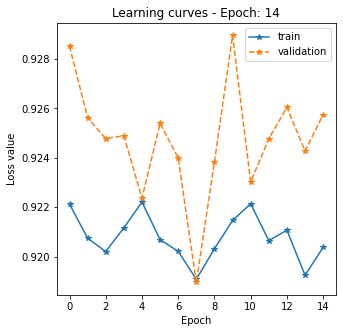

In [ ]:
learning_curves = {"train": [],
                   "validation": []}

for epoch in range(epochs):  # loop over the dataset multiple times
    # print('******** Epoch [{}/{}]  ********'.format(epoch+1, epochs+1))

    model.train()

    # train for one epoch
    train_loss_ = train_loop(train_loader, model, criterion, optimizer, writer, epoch)


    # evaluate on validation set
    with torch.no_grad():   # Disable gradient computation (faster and saves memory)
        model.eval()        # Disable Dropout and BatchNormalization
        val_loss = train_loop(val_loader, model, criterion, optimizer, writer, epoch)

    learning_curves['train'] += [train_loss_.item()]
    learning_curves['validation'] += [val_loss.item()]

    # Visualisez les courbes d'apprentissage
    plt.figure(figsize=(5, 5))
    plt.plot(learning_curves['train'], '-*', label="train")
    plt.plot(learning_curves['validation'], '--*', label="validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss value")
    plt.legend()
    plt.title(f"Learning curves - Epoch: {epoch}")
    plt.show()
    clear_output(wait=True)

    # if save_model and epoch % save_frequency == 0:
        # save_checkpoint({'epoch': epoch,
        #                 'state_dict': model.state_dict(),
        #                  'val_loss': val_loss,
        #                  'optimizer': optimizer.state_dict()}, model_path)


### Visualisation sur Tensorboard

In [ ]:
# !tensorboard --logdir=./Brats/save/tensorboard_logs/

%reload_ext tensorboard
%tensorboard --logdir './Brats/save/tensorboard_logs/'

# logs = './Brats/save/tensorboard_logs/'
from tensorboard import notebook
notebook.list() # View open TensorBoard instances
notebook.display(port=6006, height=1000)

<IPython.core.display.Javascript object>

Known TensorBoard instances:
  - port 6006: logdir ./Brats/save/tensorboard_logs/ (started 0:00:00 ago; pid 2030)
Selecting TensorBoard with logdir ./Brats/save/tensorboard_logs/ (started 0:00:00 ago; port 6006, pid 2030).


<IPython.core.display.Javascript object>

In [ ]:
# Load the saved checkpoint
checkpoint = torch.load('model_checkpoint_0.pth')

# Load the state_dict into the model
model.load_state_dict(checkpoint['model_state_dict'])

# **6. Prediction et Evaluation**


Après avoir entraîné votre modèle, nous devons maintenant:

1.  Utiliser le modèle pour prédire une segmentation.

2.  Evaluer les performances du modèles sur le test set.

L'évaluation du modèle doit être faite sur le test set, qui n'a pas été vu pendant le training. Le validation set n'était utile que pour contrôler les éventuels problèmes d'overfitting / underfitting.





## 6.a. Prediction et retour à l'espace d'origine

Dans cet exercice:
>- Nous allons charger le modèle pré-entraîné et utiliser la fonction `predict()` pour prédire une segmentation.
>- La segmentation prédite aura pour taille `(96, 96, 4)`, pour une coupe selon l'axe Z.
>- Afin de faire la comparaison avec les data d'origine, il est nécessaire de retransformer la prédiction en un volume de taille `(155, 240, 240)`.

Afin de faire cela, il faudra:

- Appliquer la fonction `predict()` à un dataloader. Dans cette étape d'évaluation, il n'y a pas besoin de faire de rétropropagation ni de mettre à jour les paramètres du modèle.
- Appliquer la fonction `reconstruct_patient()` afin de reconstruire un volume entier pour un patient donné.
- Appliquer la fonction  `get_mask2original_shape()` à la prédiction pour passer d'une taille `(78, 4, 96, 96)` à `(155, 240, 240)`

**Questions**
- Complétez la fonction `predict()`
- Etudiez la fonction `get_mask2original_shape()`. Que font les différentes fonctions internes ? Essayez de deviner les tailles de chaque variable.


In [ ]:
def predict(loader, model, batch_size=1):
    preds = {}
    for i, sample in tqdm(enumerate(loader, 1)):
        # Take variable and put them to GPU
        (irms, masks, patients) = sample

        irms = irms.float().cuda()
        masks = masks.float().cuda()

        batch_patient_names, batch_z_slices = patients[0], patients[1]

        # compute output
        pred_masks = model(irms)

        # Put the predictions in a dictionnary with one key being the
        # patient and the z slice
        n_batch = len(pred_masks)
        for j in range(n_batch):
            patient, z_slice = batch_patient_names[j], batch_z_slices[j]
            name = patient + '_z_' + str(to_numpy(z_slice))
            preds[name] = to_numpy(pred_masks[j])
    return preds

def reconstruct_patient(preds, patient, z_max = 78):
    '''
    From the dictionnary with prediction find the slice corresponding to
    one patient and construct a 3D matrix of shape 77*96*96
    '''
    X = []
    for i in range(z_max):
        name = patient + '_z_' + str(i)
        array_slice = preds[name]
        X.append(array_slice)
    X = np.stack(X, axis=0)
    return X


def get_mask2original_shape(predict_mask):
    mask = np.zeros(shape=(155,240, 240))
    res = skimage.transform.resize(predict_mask, (155, 4, 192, 192))
    res = res > 0.5
    res = np.argmax(res, axis=1)
    mask[:, 24:-24, 24:-24] = res
    mask[mask == 3] = 4
    return mask.astype('int')

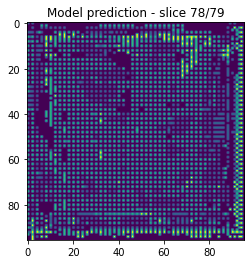

Mask shape: (78, 4, 96, 96)
Resized mask shape: (155, 240, 240)


In [ ]:
test_path = original_data_path
patients = [os.path.basename(p) for p in glob(test_path + "*")]
patient = patients[0]

model.eval()
# Make prediction
with torch.no_grad():
    preds = predict(test_loader, model)

# reconstruct the patient's complete volume
predict_mask = reconstruct_patient(preds, patient)

for i in range(len(predict_mask)):
    plt.figure()
    plt.title("Model prediction - slice {}/{}".format(i+1, len(predict_mask)+1))
    plt.imshow(np.argmax(predict_mask[i, ...], axis=0))
    plt.show()
    clear_output(wait=True)

print("Mask shape:", predict_mask.shape)

# Return to original shape
predict_mask = get_mask2original_shape(predict_mask)


print("Resized mask shape:", predict_mask.shape)


In [ ]:
# def numpy2sitk(predict_mask, orig_img):
#     '''
#     Input : predict_mask of type numpy array
#             orig_img of type SimpleITK image
#     Output : new_img of type SimpleITK image
#     '''
#     new_img = sitk.GetImageFromArray(predict_mask)
#     new_img.SetDirection(orig_img.GetDirection())
#     new_img.SetOrigin(orig_img.GetOrigin())
#     new_img.SetSpacing(orig_img.GetSpacing())
#     return new_img

# predict_img = numpy2sitk(predict_mask, orig_image)
# path = os.path.join(patient_folder, patient + '_predict_seg.nii.gz')
# sitk.WriteImage(predict_img, path)

## 6.b. Comparaison visuelle


Nous allons faire une comparaison qualitative entre la segmentation prédite par le modèle et la segmentation de référence.


**Questions**
- Chargez la segmentation de référence (dans le dossier `/Brats/origin_data`) et, en utilisant les fonctions `plt.subplot`, `plt.imshow` et `plt.title`, affichez le masque de segmentation prédit par le modèle, et la segmentation de référence côte à côte.

- Etudiez la fonction `numpy2nifti`. Que fait-elle ? Appliquez-là et sauvegardez les masques de segmentation prédits sous format nifti `.nii`.

In [ ]:
# Compare visual plot of prediction and original mask
import matplotlib.pyplot as plt

patient_folder = os.path.join(test_path, patient)
orig_image = sitk.ReadImage(os.path.join(patient_folder, patient  + '_seg.nii.gz' ))
orig_mask = sitk.GetArrayFromImage(orig_image)

z_slice=100
for z_slice in range(orig_mask.shape[0]):
    plt.figure(figsize=(13, 6))

    plt.subplot(1,2,1)
    plt.imshow(orig_mask[z_slice, :,: ], vmin=0, vmax=4)
    plt.title('Original mask (slice {})'.format(z_slice))

    plt.subplot(1,2,2)
    plt.imshow(predict_mask[z_slice, :,: ], vmin=0, vmax=4)
    plt.title('Predicted mask (slice {})'.format(z_slice))

    plt.show()

    clear_output(wait=True)

## 6.c. Metrics


Nous allons maintenant calculer les métriques d'évaluation pour valider la performance du modèle.

Nous allons utiliser 3 métriques:
- la sensitivité (aussi appelée le taux de vrais positifs),
- la spécificité (aussi appelée le taux de vrais négatifs),
- le Dice score (qui est modifier lorsqu'il s'agit de la loss pendant l'entraînement en 1 - Dice score).

Nous allons évaluer le modèle selon ces métriques en considérant les 5 patients du dossier `/Brats/origin_data`. Dans les applications réelles, nous devrions évaluer les métriques sur les patients du test set.

**En exécutant ce qui suit :**
- En utilisant les arrays `predict_mask` and `orig_mask` précédents, vous calculez les métriques. Vous avez juste à appliquer la fonction `evalAllSample()`.
- En utilisant une boucle `for`et toutes les fonctions définies dans la partie 3 du TP, vous calculez les métriques pour les patients du dossier `/Brats/origin_data`, et affichez les valeurs moyennes de Dice pour chaque catégorie (WT, ET, TC).




In [ ]:
import pandas as pd

def metrics(mask_, gt_):
    '''
    Taking to binary array of same shape as input
    This function compute the confusion matrix and use it to calculate
    Dice metrics, Sensitivity and Specificity
    Input : mask_, gt_ numpy array of identic shape (only 1 and 0)
    Output : List of 3 scores
    '''
    lnot = np.logical_not
    land = np.logical_and

    true_positive = np.sum(land((mask_), (gt_)))
    false_positive = np.sum(land((mask_), lnot(gt_)))
    false_negative = np.sum(land(lnot(mask_), (gt_)))
    true_negative = np.sum(land(lnot(mask_), lnot(gt_)))

    M = np.array([[true_negative, false_negative],
                [false_positive, true_positive]]).astype(np.float64)
    metrics = {}
    metrics['Sensitivity'] = M[1, 1] / (M[0, 1] + M[1, 1])
    metrics['Specificity'] = M[0, 0] / (M[0, 0] + M[1, 0])
    metrics['Dice'] = 2 * M[1, 1] / (M[1, 1] * 2 + M[1, 0] + M[0, 1])
    # metrics may be NaN if denominator is zero! use np.nanmean() while
    # computing average to ignore NaNs.

    return [metrics['Dice'], metrics['Sensitivity'], metrics['Specificity']]


def evalAllSample(mask_, gt_):
    '''
    This functions takes as input two numpy arrays with labels between
    0, 1, 2 and 4 and calculate the metrics as defined in BraTS data challenge
    mask_ and gt_ should be array of int
    '''
    # whole tumor (labels 1,2,4)
    mask_wt, gt_wt = (np.array([0, 1, 1, 0, 1])[mask_],
                    np.array([0, 1, 1, 0, 1])[gt_])
    wt_metrics = metrics(mask_wt, gt_wt)

    # tumor core (labels 1,4)
    mask_tc, gt_tc = (np.array([0, 1, 0, 0, 1])[mask_],
                    np.array([0, 1, 0, 0, 1])[gt_])
    tc_metrics = metrics(mask_tc, gt_tc)

    # enhancing tumor (label 4)
    mask_et, gt_et = (np.array([0, 0, 0, 0, 1])[mask_],
                    np.array([0, 0, 0, 0, 1])[gt_])
    et_metrics = metrics(mask_et, gt_et)

    return pd.DataFrame({'wt': wt_metrics, 'tc': tc_metrics, 'et': et_metrics},
                      index=['Dice', 'Sensitivity', 'Specificity'])

In [ ]:
wt_dice_list = []
et_dice_list = []
tc_dice_list = []

model.eval()
with torch.no_grad():
    preds = predict(test_loader, model, batch_size=batch_size)

for patient in patients:
    # Path to original image
    patient_folder = os.path.join(test_path,patient)
    # Open image
    orig_image = sitk.ReadImage(os.path.join(patient_folder,
                                            patient  + '_seg.nii.gz'))
    # Convert image to numpy array
    orig_mask = sitk.GetArrayFromImage(orig_image)

    # Reconstruct the whole patient predicted mask
    predict_mask = reconstruct_patient(preds, patient)
    predict_mask = get_mask2original_shape(predict_mask)

    print('*********** {} ***********'.format(patient))
    scores = evalAllSample(predict_mask, orig_mask)
    print(scores)
    print("\n")

    wt_dice_list.append(scores.loc['Dice', 'wt'])
    et_dice_list.append(scores.loc['Dice', 'et'])
    tc_dice_list.append(scores.loc['Dice', 'tc'])

In [ ]:
print('Whole Tumor Dice : {:.2f}'.format(np.mean(wt_dice_list)))
print('Tumor Core Dice : {:.2f}'.format(np.mean(et_dice_list)))
print('Enhancing Tumor Dice : {:.2f}'.format(np.mean(tc_dice_list)))

# **7. Data Augmentation**
 Dans cette partie, nous allons utiliser des techniques de data augmentation afin d'améliorer les performances du modèle. Parce que les réseaux de neurones convolutifs sont invariants par translation uniquement, l'idée est de créer des échantillons artificiels à partir des données du training set pour que le modèle "voie" plus de données et apprenne à mieux généraliser et donc à affiner ses prédictions
 .



In [ ]:
k = 3

irms, masks, patient = val_loader.__iter__().next()

# irms is a list of a numpy array of shape [Batch * W*H*Modality]
irm = irms[0,:].numpy()
mask = masks[0,:].numpy()

fig = plot(irm, mask)
fig.suptitle('Original image')
fig.savefig(save_path + 'orig.png')

## 7.a. Etude de l'augmentation de données.

Complétez le code suivant afin de visualiser les effets de différentes techniques d'augmentation de données implémentées.

In [ ]:
import scipy
import scipy.ndimage
import numpy as np

class AxialFlip(object):

    def __call__(self, sample):
        choice_x = np.random.randint(0, 2)
        choice_y = np.random.randint(0, 2)
        irm, mask = sample
        new_sample = (self.axialflip(irm, choice_x, choice_y),
                      self.axialflip(mask, choice_x, choice_y))
        return new_sample

    def axialflip(self, array, choice_x, choice_y):
        if choice_x == 1:  array = array[:, ::-1, :]
        if choice_y == 1:  array = array[:, ::-1, ::-1]
        return np.ascontiguousarray(array)

class RandomRotation90(object):
    '''
        Taken from augment_rot90 from MIC-DKFZ/batchgenerators
        https://github.com/MIC-DKFZ/batchgenerators/blob/master/batchgenerators/augmentations/spatial_transformations.py
    '''

    def __init__(self, num_rot=(1, 2, 3, 4)):
        self.num_rot = num_rot
        self.axes = (1,2)

    def __call__(self, sample):
        '''
          irm and mask have shape (Modality*Width*Height) and (Label*Width*Height)
        '''
        num_rot = np.random.choice(self.num_rot)
        def f(img):
            return np.ascontiguousarray(np.rot90(img, num_rot, self.axes))

        irm, mask = sample
        new_sample = (f(irm), f(mask))
        return new_sample

class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, cubic crop
            is made.
    """
    def __init__(self, output_size, dim=2):
        assert isinstance(output_size, (int, tuple, list))
        if isinstance(output_size, int):
            self.output_size = dim * (output_size,)
        else:
            assert len(output_size) == dim
            self.output_size = output_size

    def __call__(self, sample):
        irm, mask = sample
        _, height, width = irm.shape
        i = np.random.randint(0, height - self.output_size[0])
        j = np.random.randint(0, width - self.output_size[1])

        def f(img):
            return img[:, i: i + self.output_size[0], j : j + self.output_size[1]]

        new_sample = ( f(irm), f(mask))
        return new_sample

def RandomTranslation(max_translation=30, transform_matrix=None, debug=False):
    translation = np.random.randint(-max_translation, max_translation, 2)
    if debug:
        return getTranslationMatrix(translation, transform_matrix), (translation)
    else:
        return getTranslationMatrix(translation, transform_matrix)

def RandomRotation(theta_max=20, transform_matrix=None, debug=False):
    theta = np.random.uniform(-theta_max, theta_max)
    if debug:
        return getRotationMatrix(theta, transform_matrix), theta
    else:
        return getRotationMatrix(theta, transform_matrix)

def RandomZoom(zoom_max=0.2, transform_matrix=None, debug=False):
    zoom = np.random.uniform(1 - zoom_max, 1 + zoom_max)
    if debug:
          return getZoomMatrix(zoom, transform_matrix), zoom
    else:
        return getZoomMatrix(zoom, transform_matrix)

def getTranslationMatrix(translation, transform_matrix=None):
    '''
        2D translation on the axis (0, 1).
        Axis 3 is the modality axis
        tx: Width shift.
        ty: Heigh shift.

    '''
    shift_matrix = np.array([[1, 0, translation[0]],
                            [0, 1, translation[1]],
                            [0, 0, 1]])

    if transform_matrix is None:
        transform_matrix = shift_matrix
    else:
        transform_matrix = np.dot(transform_matrix, shift_matrix)
    return transform_matrix

def getZoomMatrix(zoom, transform_matrix=None):
    '''
        Affine Zoom in 2D
        zx: Zoom in x direction.
        zy: Zoom in y direction
    '''
    zoom_matrix = np.array([[zoom, 0, 0],
                            [0, zoom, 0],
                            [0, 0, 1]])
    if transform_matrix is None:
        transform_matrix = zoom_matrix
    else:
        transform_matrix = np.dot(transform_matrix, zoom_matrix)
    return transform_matrix

def getRotationMatrix(theta, transform_matrix=None):
    '''
        2D rotation on the axis (0, 1).
        Axis 3 is the modality axis
        theta: Rotation angle in degrees.
    '''
    theta = np.deg2rad(theta)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])
    if transform_matrix is None:
        transform_matrix = rotation_matrix
    else:
        transform_matrix = np.dot(transform_matrix, rotation_matrix)
    return transform_matrix


def apply_affine_transform(x, seg=None, transform_matrix=None, crop_shape=None,
                           fill_mode='nearest', cval=0., order=3):
    """Applies an affine transformation specified by the parameters given.
    # Arguments
        x: 4D numpy array, single image, multimodalities (Modality*H*W)
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
        order: int, order of interpolation
    # Returns
        The transformed version of the input.
    """
    if scipy is None:
        raise ImportError('Image transformations require SciPy. '
                          'Install SciPy.')
    if transform_matrix is not None:
        channels, h, w = x.shape
        transform_matrix = transform_matrix_offset_center(transform_matrix,
                                                          h, w)
        res = [ scipy.ndimage.affine_transform(x[channel, ...], transform_matrix,
                                              order=order, mode=fill_mode, cval=cval)  for channel in range(channels)]
        x = np.stack(res, axis=0)

        if seg is not None:
            labels = seg.shape[0]
            res = [scipy.ndimage.affine_transform(seg[label, ...], transform_matrix,
                                                                order=order, mode=fill_mode, cval=cval) for label in range(labels)]
            seg = np.stack(res, axis=0)
            seg[seg > 0.5] = 1
            seg[seg < 0.5] = 0
            return x, seg
    return x

def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x],
                              [0, 1, o_y],
                              [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x],
                             [0, 1, -o_y],
                             [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

class AffineTransform(object):

    def __init__(self, theta=0, max_translation=0, max_zoom=0):
        self.theta = theta
        self.max_translation = max_translation
        self.max_zoom = max_zoom

    def __call__(self, sample):
        transform_matrix = np.eye(3)
        if self.theta > 0:
            transform_matrix = RandomRotation(self.theta)
        if self.max_translation > 0:
            transform_matrix = RandomTranslation(self.max_translation,
                                                 transform_matrix)
        if self.max_zoom > 0:
            transform_matrix = RandomZoom(self.max_zoom,
                                          transform_matrix)
        new_irm, new_mask = apply_affine_transform(irm, mask, transform_matrix)
        return (new_irm, new_mask)


Axial Flip

In [ ]:
flip = AxialFlip()
for i in range(k):

    (new_irm, new_mask) = flip((irm, mask))

    fig = plot(new_irm, new_mask)
    fig.suptitle('Random Axial Flip')
    fig.savefig(save_path + 'Axial_Flip{}.png'.format(k))

90° Rotation

In [ ]:
random90rotation = RandomRotation90()
for i in range(k):

    (new_irm, new_mask) = random90rotation((irm, mask))

    fig = plot(new_irm, new_mask)
    fig.suptitle('Random 90 degrees Rotation')
    fig.savefig(save_path + 'Random90Rotation{}.png'.format(k))

In [ ]:
randomcrop = RandomCrop((64, 64))
for i in range(k):

    (new_irm, new_mask) = randomcrop((irm, mask))

    fig = plot(new_irm, new_mask)
    fig.suptitle('Random crop')
    fig.savefig(save_path + 'Random90Rotation{}.png'.format(k))

Random Rotation with +/- 30°

In [ ]:
rotate = AffineTransform(theta=30)

for i in range(k):


    (new_irm, new_mask) = rotate((irm, mask))

    fig = plot(new_irm, new_mask)
    fig.suptitle('Random rotation')
    fig.savefig(save_path + 'Rotation{:.1f}.png'.format(i))


Random Translation

In [ ]:
translate = AffineTransform(max_translation=30)

for i in range(k):
    new_irm, new_mask  = translate((irm, mask))

    fig = plot(new_irm, new_mask)
    fig.suptitle('Random translation')
    fig.savefig(save_path + 'Translation_{}.png'.format(i))

Random Zoom

In [ ]:
zoom = AffineTransform(max_zoom=0.5)

for i in range(k):
    (new_irm, new_mask)  = zoom((irm, mask))

    fig = plot(new_irm, new_mask)
    fig.suptitle('Random zoom ')
    fig.savefig(save_path + 'Zoom_{}.png'.format(k))

All transformations

In [ ]:
affine_transform = AffineTransform(theta=30, max_translation=30,
                       max_zoom=0.5)

for i in range(k):
    (new_irm, new_mask)  = affine_transform((irm, mask))

    fig = plot(new_irm, new_mask)
    fig.suptitle('Rotation Translation Zoom')
    fig.savefig(save_path + 'All_transforms{}.png'.format(i))

## 7.b. Entraînement avec data augmentation

Relancer un nouvel entraînement avec les techniques d'augmentation de données dans `transformation`.

In [ ]:
transforms_list = [AffineTransform(theta=15, max_translation=15, max_zoom=0.3),
                   AxialFlip(), RandomRotation90(), RandomCrop((64, 64))
                   ]

transformation = torchvision.transforms.Compose(transforms_list)


train_Dataset = SegmentationDataset(train_IDs, data_path=data_path,
                                    transform=transformation
                                    )

val_Dataset = SegmentationDataset(val_IDs, data_path=data_path,
                                  transform=transformation
                                  )

test_Dataset = SegmentationDataset(test_IDs, data_path=data_path,
                                  transform=None
                                  )

train_loader_data_augment = torch.utils.data.DataLoader(train_Dataset,
                                           batch_size=batch_size, shuffle=True,
                                           drop_last=True)

val_loader_data_augment = torch.utils.data.DataLoader(val_Dataset,
                                         batch_size=batch_size, drop_last=True)

test_loader_data_augment = torch.utils.data.DataLoader(test_Dataset,
                                         batch_size=1, drop_last=False)

In [ ]:
learning_rate = 1e-4
image_size = (96, 96)
n_modalities = 4
n_labels = 4
epochs = 10
batch_size = 64
print_frequency = 5
save_frequency = 10
save_model = True
tumor_percentage = 0.5
tensorboard = True

In [ ]:
model = UNet(n_channels=n_modalities, n_classes=n_labels) # Create model
model.cuda() # move model to GPU

criterion = mean_dice_loss # Choose loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Choose optimizer

# Keep logs of training metrics. To visualize with tensorbard.
log_dir = tensorboard_folder + session_name + '/'
if not os.path.isdir(log_dir):
    os.makedirs(log_dir)
writer = torch.utils.tensorboard.SummaryWriter(log_dir)

learning_curves = {"train": [],
                   "validation": []}
for epoch in range(epochs):  # loop over the dataset multiple times
    # train for one epoch
    model.train()
    train_loss_ = train_loop(train_loader_data_augment, model, criterion,
               optimizer, writer, epoch)

    # evaluate on validation set
    with torch.no_grad():  # Don't compute gradients
        model.eval()       # Deactivate any BarchNormalization or Dropout layer
        val_loss = train_loop(val_loader_data_augment, model, criterion,
                              optimizer, writer, epoch)

    learning_curves['train'] += [train_loss_.item()]
    learning_curves['validation'] += [val_loss.item()]

    # Visualisez les courbes d'apprentissage
    plt.figure(figsize=(5, 5))
    plt.plot(learning_curves['train'], '-*', label="train")
    plt.plot(learning_curves['validation'], '--*', label="validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss value")
    plt.legend()
    plt.title(f"Learning curves - Epoch: {epoch}")
    plt.show()
    clear_output(wait=True)

    # Saving the optimizer state allows to do further fine tuning later.
    if save_model and epoch % save_frequency == 0:
        save_checkpoint({'epoch': epoch,
                        'state_dict': model.state_dict(),
                         'val_loss': val_loss,
                         'optimizer': optimizer.state_dict()}, model_path)


In [ ]:
# Load the saved checkpoint
checkpoint = torch.load('model_checkpoint_1.pth')

# Load the state_dict into the model
model.load_state_dict(checkpoint['model_state_dict'])

## 7.c. Evaluation du modèle

Exécutez le code suivant pour évaluer le modèle.

In [ ]:
test_path = original_data_path
patients = [os.path.basename(p) for p in glob(test_path + "*")]
patient = patients[0]

model.eval()
with torch.no_grad():
    preds = predict(test_loader_data_augment, model, batch_size=batch_size)


predict_mask = reconstruct_patient(preds, patient)


plt.figure()
plt.title("Model prediction")
plt.imshow(np.argmax(predict_mask[50, ...], axis=0))
plt.show()

print("Mask shape:", predict_mask.shape)

predict_mask = get_mask2original_shape(predict_mask)
print("Resized mask shape:", predict_mask.shape)

In [ ]:
wt_dice_list = []
et_dice_list = []
tc_dice_list = []

model.eval()
with torch.no_grad():
    preds = predict(test_loader, model, batch_size=batch_size)

for patient in patients:
    # Path to original image
    patient_folder = os.path.join(test_path,patient)
    # Open image
    orig_image = sitk.ReadImage(os.path.join(patient_folder,
                                            patient  + '_seg.nii.gz' ))
    # Convert image to numpy array
    orig_mask = sitk.GetArrayFromImage(orig_image)

    # Reconstruct the whole patient predicted mask
    predict_mask = reconstruct_patient(preds, patient)
    predict_mask = get_mask2original_shape(predict_mask)

    print('*********** {} ***********'.format(patient))
    scores = evalAllSample(predict_mask, orig_mask)
    print(scores)
    print("\n")

    wt_dice_list.append(scores.loc['Dice', 'wt'])
    et_dice_list.append(scores.loc['Dice', 'et'])
    tc_dice_list.append(scores.loc['Dice', 'tc'])

In [ ]:
print('Whole Tumor Dice : {:.2f}'.format(np.mean(wt_dice_list)))
print('Tumor Core Dice : {:.2f}'.format(np.mean(et_dice_list)))
print('Enhancing Tumor Dice : {:.2f}'.format(np.mean(tc_dice_list)))

# **8. Load an architecture from GitHub**

In the following code you will learn how to get an architure directly from a github repository.

The github that we are cloning is [here](https://github.com/soniamartinot/BraTs_models)

In [ ]:

!git clone https://github.com/soniamartinot/BraTs_models.git

Cloning into 'BraTs_models'...
remote: Enumerating objects: 1322, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 1322 (delta 30), reused 1 (delta 0), pack-reused 1273
Receiving objects: 100% (1322/1322), 18.80 MiB | 16.38 MiB/s, done.
Resolving deltas: 100% (826/826), done.


In [ ]:
from BraTs_models.pytorch.models.deeplab import Deeplab_V3_Plus

model = Deeplab_V3_Plus(class_num=4, n_input_channels=4, drop_rate=0)
x = torch.rand(16, 4, 128, 128)
model(x).shape

torch.Size([16, 4, 128, 128])

In [ ]:
model.cuda()

Deeplab_V3_Plus(
  (resnet): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (dp): Dropout2d(p=0, inplace=False)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (dp): Dropout2d(p=0, inplace=False)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [ ]:
learning_curves = {"train": [],
                   "validation": []}

for epoch in range(epochs):  # loop over the dataset multiple times
    # print('******** Epoch [{}/{}]  ********'.format(epoch+1, epochs+1))

    model.train()

    # train for one epoch
    train_loss_ = train_loop(train_loader, model, criterion, optimizer, writer, epoch)


    # evaluate on validation set
    with torch.no_grad():   # Disable gradient computation (faster and saves memory)
        model.eval()        # Disable Dropout and BatchNormalization
        val_loss = train_loop(val_loader, model, criterion, optimizer, writer, epoch)

    learning_curves['train'] += [train_loss_.item()]
    learning_curves['validation'] += [val_loss.item()]

    # Visualisez les courbes d'apprentissage
    plt.figure(figsize=(5, 5))
    plt.plot(learning_curves['train'], '-*', label="train")
    plt.plot(learning_curves['validation'], '--*', label="validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss value")
    plt.legend()
    plt.title(f"Learning curves - Epoch: {epoch}")
    plt.show()
    clear_output(wait=True)

    # if save_model and epoch % save_frequency == 0:
        # save_checkpoint({'epoch': epoch,
        #                 'state_dict': model.state_dict(),
        #                  'val_loss': val_loss,
        #                  'optimizer': optimizer.state_dict()}, model_path)


KeyboardInterrupt: ignored

In [ ]:
# Load the saved checkpoint
checkpoint = torch.load('model_checkpoint_2.pth')

# Load the state_dict into the model
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
wt_dice_list = []
et_dice_list = []
tc_dice_list = []

model.eval()
with torch.no_grad():
    preds = predict(test_loader, model, batch_size=batch_size)

for patient in patients:
    # Path to original image
    patient_folder = os.path.join(test_path,patient)
    # Open image
    orig_image = sitk.ReadImage(os.path.join(patient_folder,
                                            patient  + '_seg.nii.gz' ))
    # Convert image to numpy array
    orig_mask = sitk.GetArrayFromImage(orig_image)

    # Reconstruct the whole patient predicted mask
    predict_mask = reconstruct_patient(preds, patient)
    predict_mask = get_mask2original_shape(predict_mask)

    print('*********** {} ***********'.format(patient))
    scores = evalAllSample(predict_mask, orig_mask)
    print(scores)
    print("\n")

    wt_dice_list.append(scores.loc['Dice', 'wt'])
    et_dice_list.append(scores.loc['Dice', 'et'])
    tc_dice_list.append(scores.loc['Dice', 'tc'])